# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")

fatal: destination path 'LightGlue' already exists and is not an empty directory.
/home/hemant/Downloads/amit/ALIKE_code/LightGlue


/home/hemant/anaconda3/envs/amit_kaggle/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

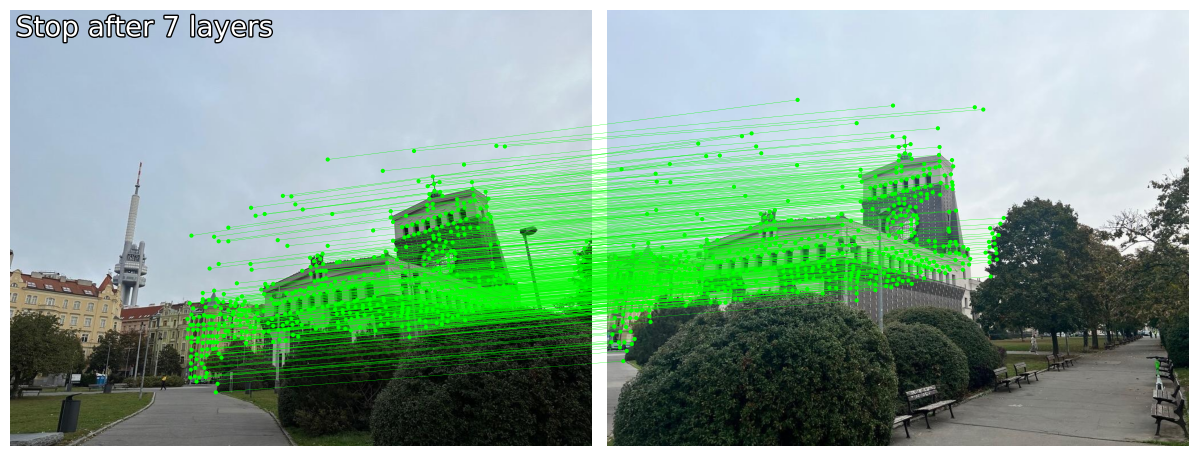

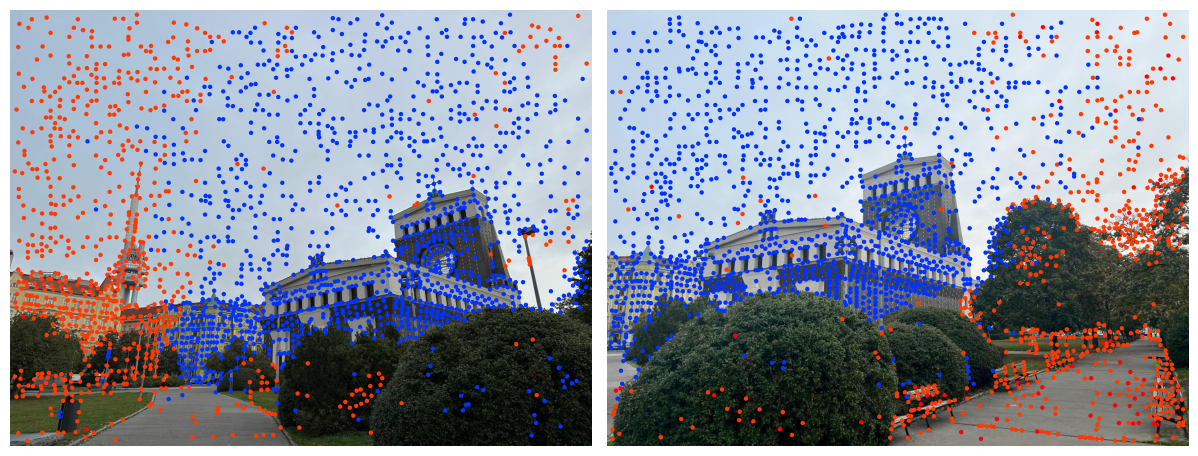

In [3]:
image0 = load_image("/home/hemant/Downloads/amit/ALIKE_code/data/train/church/images/00001.jpg")
image1 = load_image("/home/hemant/Downloads/amit/ALIKE_code/data/train/church/images/00002.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

feats0 -  {'keypoints': tensor([[[129., 557.],
         [ 90., 488.],
         [687., 463.],
         ...,
         [262., 579.],
         [325., 432.],
         [811., 388.]]], device='cuda:0'), 'keypoint_scores': tensor([[0.7172, 0.6526, 0.6440,  ..., 0.0060, 0.0060, 0.0060]],
       device='cuda:0'), 'descriptors': tensor([[[ 0.0150,  0.0309,  0.0581,  ...,  0.1898, -0.0406,  0.0188],
         [ 0.0531, -0.0713, -0.0318,  ...,  0.1008, -0.0907,  0.1503],
         [ 0.0072, -0.1350, -0.0748,  ...,  0.0981, -0.0174, -0.0361],
         ...,
         [-0.0372, -0.0658, -0.0434,  ..., -0.0806,  0.0215, -0.0432],
         [ 0.0354,  0.0430,  0.0160,  ..., -0.1983, -0.0084,  0.0057],
         [ 0.0523, -0.0169, -0.0387,  ...,  0.0717, -0.0647,  0.0056]]],
       device='cuda:0'), 'image_size': tensor([[1024.,  768.]], device='cuda:0')}
feats1 -  {'keypoints': tensor([[[309., 671.],
         [288., 801.],
         [288., 838.],
         ...,
         [264.,  79.],
         [253., 564.],
   

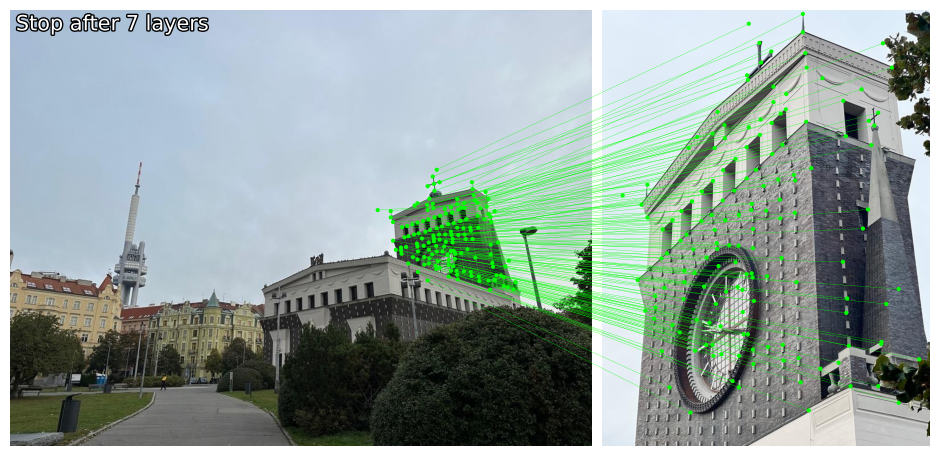

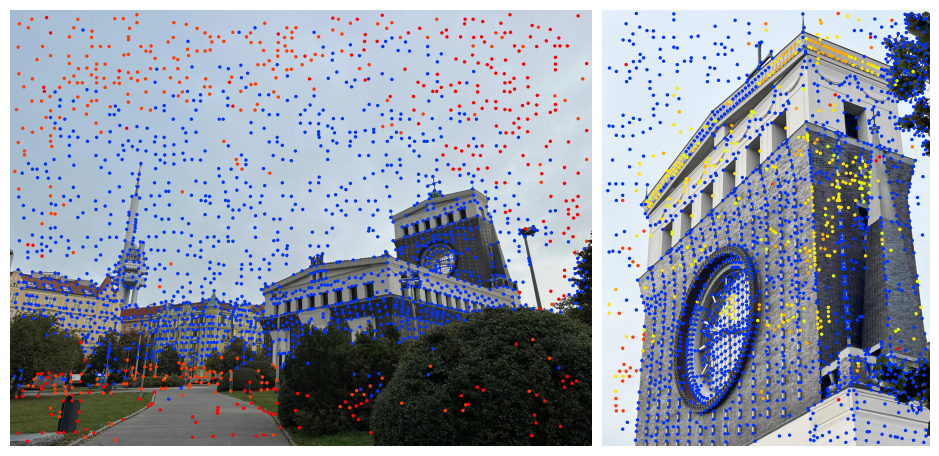

In [7]:
image0 = load_image("/home/hemant/Downloads/amit/ALIKE_code/data/train/church/images/00001.jpg")
image1 = load_image("/home/hemant/Downloads/amit/ALIKE_code/data/train/church/images/00111.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
print("feats0 - ",feats0)
print("feats1 - ",feats1)
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)

In [1]:
import subprocess as sp
import os

def get_total_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.total --format=csv"
    memory_total_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_total_values = [int(x.split()[0]) for i, x in enumerate(memory_total_info)]
    return memory_total_values

def get_free_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

def get_used_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.used --format=csv"
    memory_used_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_used_values = [int(x.split()[0]) for i, x in enumerate(memory_used_info)]
    return memory_used_values

In [2]:
import torch
import gc
from lightglue import match_pair
from lightglue import ALIKED, LightGlue
from lightglue.utils import load_image, rbd
import kornia as K
import kornia.feature as KF

def load_torch_image(fname, device=torch.device('cpu')):
    img = K.io.load_image(fname, K.io.ImageLoadType.RGB32, device=device)[None, ...]
    return img

num_features = 4096
resize_to = 1024
device=torch.device('cuda')
dtype = torch.float32 # ALIKED has issues with float16
img_path = ["/home/hemant/Downloads/amit/ALIKE_code/data/train/transp_obj_glass_cylinder/images/dsc_8233.png","/home/hemant/Downloads/amit/ALIKE_code/data/train/transp_obj_glass_cylinder/images/dsc_8232.png"]
for image in img_path:
    print(get_used_gpu_memory()[0]/1024)
    extractor = ALIKED(max_num_keypoints=num_features, detection_threshold=0.01, resize=resize_to).eval().to(device, dtype)
    print(get_used_gpu_memory()[0]/1024)
    
    image0 = load_torch_image(image, device=device).to(dtype)
    del image
    gc.collect()
    torch.cuda.empty_cache()
    print(get_used_gpu_memory()[0]/1024)
    feats0 = extractor.extract_dense_map(image0)  # auto-resize the image, disable with resize=None
    print(get_used_gpu_memory()[0]/1024)
    print(feats0[1][0,0,:,:].shape)
    del feats0
    gc.collect()
    torch.cuda.empty_cache()

0.0
0.2578125
0.57421875
39.2890625
torch.Size([4032, 6048])
0.720703125
0.72265625
0.72265625
39.416015625
torch.Size([4032, 6048])


In [37]:
print(get_used_gpu_memory()[0]/1024)
import torch
import gc
import inspect
calling_namespace = inspect.currentframe().f_back
used_vars = list(calling_namespace.f_locals.keys()
var_to_be_deleted = used_vars.copy()
print(var_to_be_deleted)
for _var in var_to_be_deleted:
    calling_namespace.f_locals.pop(_var, None)
    gc.collect()
    torch.cuda.empty_cache()
print(get_used_gpu_memory()[0]/1024)

46.4638671875
['self', 'code_obj', 'result', 'async_', '__tracebackhide__', 'old_excepthook', 'outflag']
46.4638671875


In [5]:
print(get_free_gpu_memory()[0]/1024)

10.728515625


In [2]:
import torch
import gc
# del feats0
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/1024**3)
print(torch.cuda.memory_cached()/1024**3)


0.0
0.0


/home/hemant/anaconda3/envs/amit_kaggle/lib/python3.10/site-packages/torch/cuda/memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [26]:
torch.cuda.memory_allocated()/1024**3

0.22336864471435547

In [1]:
import os
os.environ["MASTER_ADDR"]="10.130.1.74"
os.environ["MASTER_PORT"]="443"

In [2]:
print("MASTER_ADDR - ",os.environ["MASTER_ADDR"])
print("MASTER_PORT - ",os.environ["MASTER_PORT"])
import torch
import torch.distributed.rpc as rpc
rpc.init_rpc("worker0", rank=0, world_size=2)
print("Connection intiated ")
ret = rpc.rpc_sync("worker1", torch.add, args=(torch.ones(2), 3))
print("ret - ",ret)
rpc.shutdown()

MASTER_ADDR -  10.130.1.74
MASTER_PORT -  443


[W socket.cpp:464] [c10d] The server socket has failed to bind to [::]:443 (errno: 13 - Permission denied).
[W socket.cpp:464] [c10d] The server socket has failed to bind to 0.0.0.0:443 (errno: 13 - Permission denied).
[E socket.cpp:500] [c10d] The server socket has failed to listen on any local network address.


DistNetworkError: The server socket has failed to listen on any local network address. The server socket has failed to bind to [::]:443 (errno: 13 - Permission denied). The server socket has failed to bind to 0.0.0.0:443 (errno: 13 - Permission denied).

In [20]:
import torch.distributed as dist

# Use address of one of the machines
dist.init_process_group( backend="nccl",init_method='tcp://10.130.1.74:7070',
                        rank=0, world_size=4)

[E socket.cpp:957] [c10d] The client socket has timed out after 600s while trying to connect to (10.130.1.74, 7070).


DistNetworkError: The client socket has timed out after 600s while trying to connect to (10.130.1.74, 7070).